In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# This file contains all the main external libs we'll use
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [2]:
PATH = "C:/Users/Ranet/Documents/Machine Learning/games/cs_trig/data/150/"
sz=224

In [3]:
os.listdir(PATH)

['models', 'random', 'tmp', 'train', 'valid']

In [4]:
os.listdir(f'{PATH}valid')

['bg', 'shoot']

In [5]:
files = os.listdir(f'{PATH}valid/bg')[:5]
files

['100.bg.png_200.png',
 '1001.bg.png',
 '1001.bg.png_200.png',
 '1004.bg.png_200.png',
 '1006.bg.png']

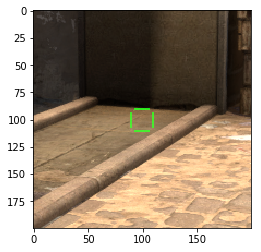

In [6]:
img = plt.imread(f'{PATH}valid/bg/{files[0]}')
plt.imshow(img);

In [7]:
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=False)
#learn.fit(0.01, 2)

In [12]:
# from here we know that 'cats' is label 0 and 'dogs' is label 1.
print(data.classes)
log_preds = learn.predict()
print(log_preds.shape)

preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(dog)

['bg', 'shoot']
(3360, 2)


In [8]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])
        
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

Correctly classified


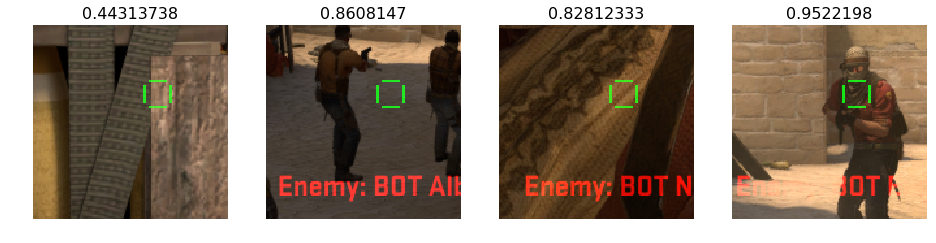

In [12]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly classified


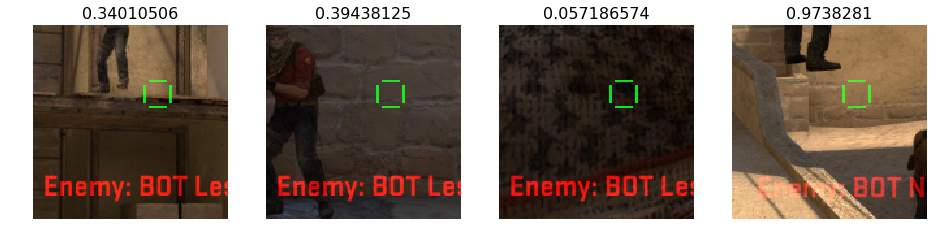

In [11]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [14]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Most correct bg


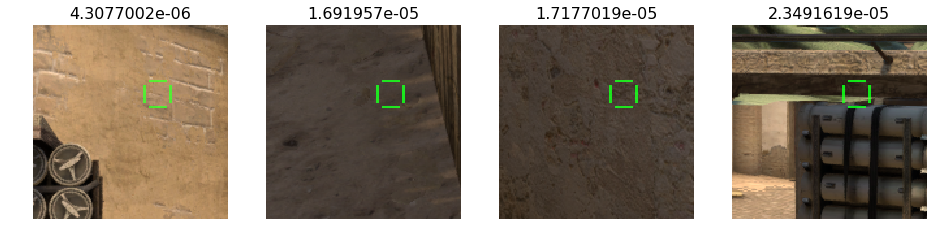

In [13]:
plot_val_with_title(most_by_correct(0, True), "Most correct bg")

Most correct shoot


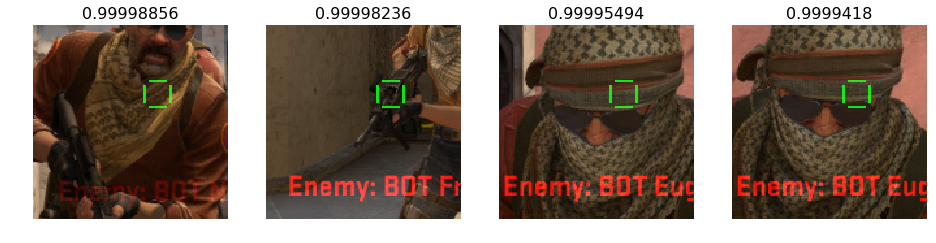

In [14]:
plot_val_with_title(most_by_correct(1, True), "Most correct shoot")

Most incorrect bg


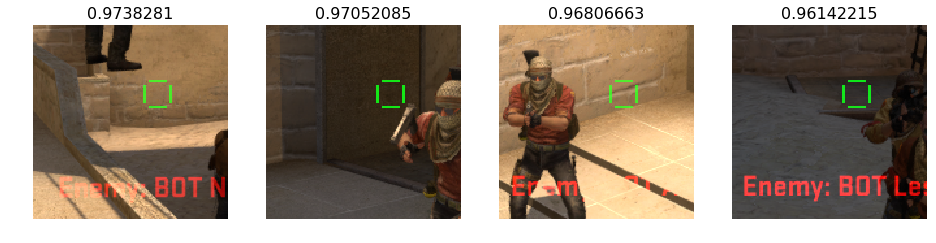

In [15]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect bg")

Most incorrect shoot


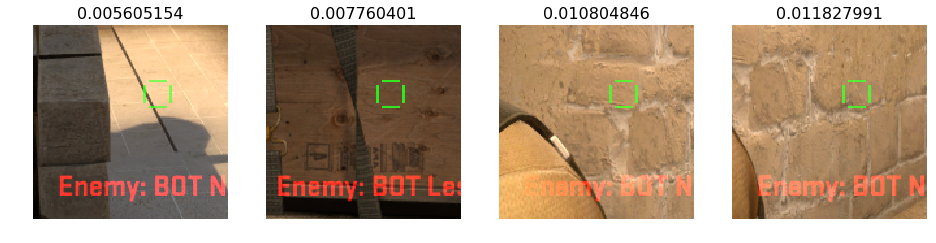

In [16]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect shoot")

Most uncertain predictions


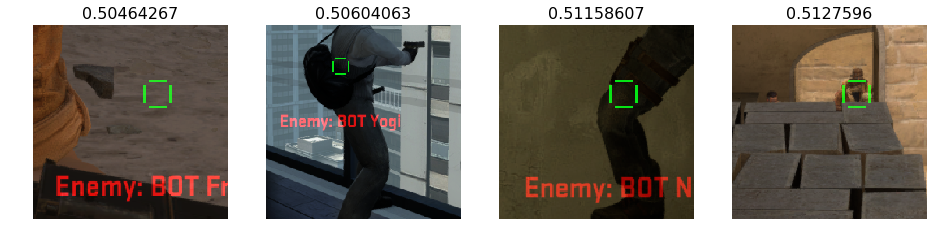

In [17]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

## Choosing a learning rate

In [7]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [16]:
lrf=learn.lr_find()

 79%|██████████████████████████████████████████████████████▊              | 360/453 [00:04<00:01, 75.69it/s, loss=1.01]


### Data augmentation

In [29]:
tfms = tfms_from_model(resnet34, sz, max_zoom=1.1)

In [30]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [31]:
ims = np.stack([get_augs() for i in range(6)])

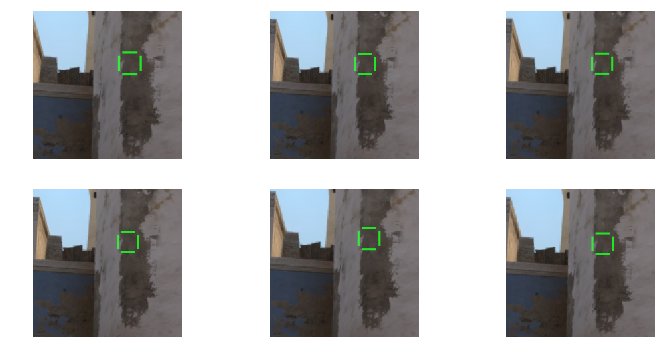

In [32]:
plots(ims, rows=2)

In [33]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [22]:
learn.fit(1e-2, 1)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.168711   0.120632   0.957738  



[array([0.12063]), 0.9577380952380953]

In [34]:
learn.precompute=False

In [24]:
learn.fit(1e-2, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.137501   0.104904   0.963988  
    1      0.127985   0.095549   0.966667                                                                              
    2      0.12066    0.090181   0.966369                                                                              



[array([0.09018]), 0.9663690476190476]

In [28]:
learn.save('csgo_lastlayer')

In [30]:
learn.load('csgo_lastlayer')

### Fine-tuning and differential learning rate annealing

In [25]:
learn.unfreeze()

In [26]:
lr=np.array([1e-4,1e-3,1e-2])

In [29]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.017338   0.053831   0.984821  
    1      0.018773   0.056267   0.983631                                                                              
  1%|▉                                                                    | 6/453 [00:04<06:01,  1.24it/s, loss=0.0174]

KeyboardInterrupt: 

Another trick we've used here is adding the `cycle_mult` parameter. Take a look at the following chart, and see if you can figure out what the parameter is doing:

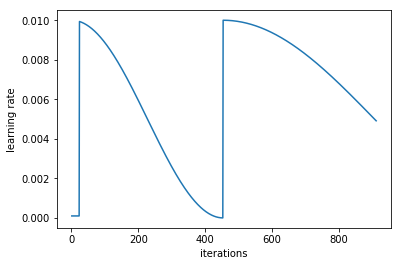

In [31]:
learn.sched.plot_lr()

Note that's what being plotted above is the learning rate of the *final layers*. The learning rates of the earlier layers are fixed at the same multiples of the final layer rates as we initially requested (i.e. the first layers have 100x smaller, and middle layers 10x smaller learning rates, since we set `lr=np.array([1e-4,1e-3,1e-2])`.

In [32]:
learn.save('csgo_all')

In [35]:
learn.load('csgo_all')

There is something else we can do with data augmentation: use it at *inference* time (also known as *test* time). Not surprisingly, this is known as *test time augmentation*, or just *TTA*.

TTA simply makes predictions not just on the images in your validation set, but also makes predictions on a number of randomly augmented versions of them too (by default, it uses the original image along with 4 randomly augmented versions). It then takes the average prediction from these images, and uses that. To use TTA on the validation set, we can use the learner's `TTA()` method.

In [12]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

In [13]:
accuracy_np(probs, y)

0.9848214285714286

I generally see about a 10-20% reduction in error on this dataset when using TTA at this point, which is an amazing result for such a quick and easy technique!

## Analyzing results

### Confusion matrix 

In [36]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

A common way to analyze the result of a classification model is to use a [confusion matrix](http://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/). Scikit-learn has a convenient function we can use for this purpose:

In [37]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

We can just print out the confusion matrix, or we can show a graphical view (which is mainly useful for dependents with a larger number of categories).

[[1624   12]
 [  36 1688]]


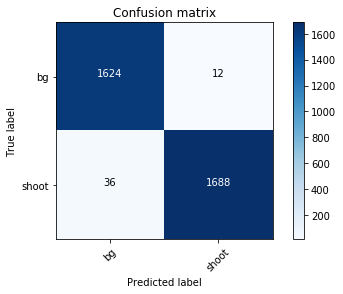

In [38]:
plot_confusion_matrix(cm, data.classes)

### Looking at pictures again

Most incorrect bg


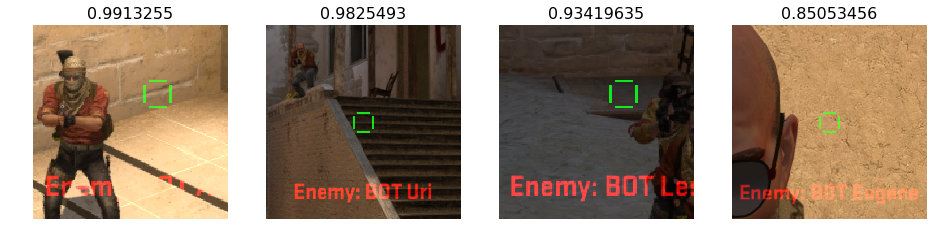

In [39]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect bg")

Most incorrect shoot


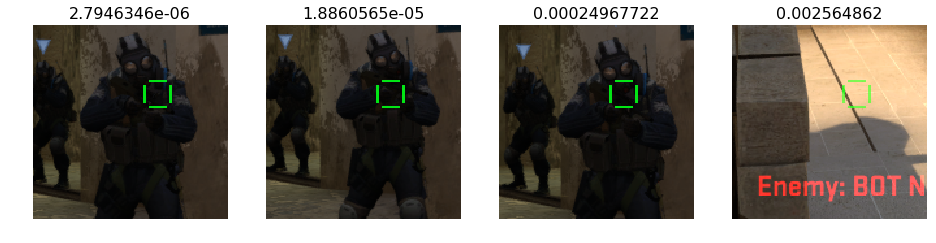

In [40]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect shoot")

# Testing on a single example

In [41]:
np.expand_dims(img, 0).shape

(1, 200, 200, 3)

In [42]:
to_predict = np.expand_dims(img, 0)
sh = to_predict.shape
to_predict = to_predict.reshape(sh[0], sh[-1], sh[1], sh[2])
print(to_predict.shape)

(1, 3, 200, 200)


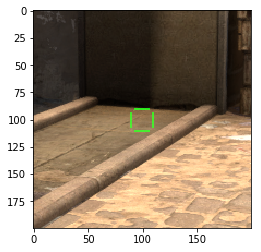

In [43]:
plt.imshow(img);

In [44]:
#log_pred = learn.predict_array(to_predict) 
log_pred = learn.model(Variable(torch.from_numpy(to_predict)).cuda()).cpu().data.numpy()

print(log_pred)
pred = np.argmax(log_pred, axis=1)  # from log probabilities to 0 or 1
prob = np.exp(log_pred[:,1])        # pr(dog)

print(pred, pred.shape)
print(prob, prob.shape)
print('Predicted:', data.classes[pred[0]])

[[-0.00018 -8.62599]]
[0] (1,)
[0.00018] (1,)
Predicted: bg


In [45]:
torch.save(learn.model, PATH + "/torch_model_v1")
the_model = torch.load(PATH + "/torch_model_v1")
the_model.eval() # shows the entire network architecture

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d

In [36]:
def predict(img):
    # Preprocess image
    #img = (img - img.mean()) / img.std()
    to_predict = np.expand_dims(img, 0)
    sh = to_predict.shape
    #to_predict = to_predict.reshape(sh[0], sh[-1], sh[1], sh[2])

    log_pred = learn.predict_array(to_predict)
    # log_pred = MODEL(Variable(torch.from_numpy(to_predict)).cuda()).cpu().data.numpy()
#     prob = np.mean(np.exp(log_pred),0)
#     print(prob, 'prob')
    pred = np.argmax(log_pred, axis=1)  # from log probabilities to 0 or 1
    
    return pred



def test_on_image(img_name):
    """ very quick method to test on a single image in /random/ folder """
    test_img = val_tfrms(np.array(Image.open('C:/Users/Ranet/Documents/Machine Learning/games/cs_trig/data/150/valid/' + img_name)))
    import pdb;pdb.set_trace()
    #test_img = np.array(Image.open('C:/Users/Ranet/Documents/Machine Learning/games/cs_trig/data/150/valid/' + img_name), dtype=np.float32)
    print(predict(test_img))

In [44]:
test_on_image("shoot/174.ter.png")
test_on_image("shoot/173.ter.png")
test_on_image("shoot/184.ter.png")
test_on_image("shoot/120.ter.png")
test_on_image("shoot/243.ter.png")
test_on_image("shoot/7716.ter.png")
test_on_image("shoot/7976.ter.png")
test_on_image("shoot/7916.ter.png")
test_on_image("shoot/8016.ter.png")
data.classes

> <ipython-input-43-874fc64b38a2>(23)test_on_image()
-> print(predict(test_img))
(Pdb) test_img
array([[[ 242.42357,  272.99127,  299.19214, ...,  447.66376,  447.66376,  452.03055],
        [ 238.05676,  277.35806,  316.6594 , ...,  460.7642 ,  460.7642 ,  460.7642 ],
        [ 233.68996,  281.72488,  329.75983, ...,  473.86462,  469.4978 ,  469.4978 ],
        ...,
        [1067.7511 , 1072.1179 , 1072.1179 , ...,  871.2445 ,  875.6113 ,  879.97815],
        [1076.4847 , 1080.8516 , 1080.8516 , ...,  884.345  ,  888.7118 ,  888.7118 ],
        [1089.5851 , 1093.9519 , 1093.9519 , ...,  901.8122 ,  901.8122 ,  901.8122 ]],

       [[ 194.39285,  216.71428,  234.57141, ...,  377.42856,  377.42856,  381.89285],
        [ 189.92856,  221.17856,  247.96428, ...,  386.35712,  386.35712,  386.35712],
        [ 189.92856,  225.64284,  261.35712, ...,  399.74997,  395.2857 ,  395.2857 ],
        ...,
        [ 899.75   ,  899.75   ,  899.75   , ...,  716.7143 ,  716.7143 ,  716.7143 ],
      

BdbQuit: 

In [42]:
test_on_image("bg/529.bg.png")
test_on_image("bg/559.bg.png")
test_on_image("bg/563.bg.png")
test_on_image("bg/5196.bg.png")
test_on_image("bg/5062.bg.png")
test_on_image("bg/5545.bg.png")
test_on_image("bg/5545.bg.png")
test_on_image("bg/5316.bg.png")
test_on_image("bg/5326.bg.png")
data.classes

[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]


['bg', 'shoot']

In [118]:
def test_on_folder(path, class_id):
    import glob
    preds = []
    for filename in glob.glob(path + '/*.png'):
        img = np.array(Image.open(filename), dtype=np.float32)
        preds.append(predict(img)[0])

    num_preds = len(preds)
    correct_count = preds.count(class_id)
    print("Num images:", num_preds)
    print("Num correct:", correct_count)
    print("Acc:", correct_count / num_preds)

test_on_folder("C:/Users/Ranet/Documents/Machine Learning/games/cs_trig/data/150/valid/shoot", 1)
test_on_folder("C:/Users/Ranet/Documents/Machine Learning/games/cs_trig/data/150/valid/bg", 0)

Num images: 1724
Num correct: 1724
Acc: 1.0
Num images: 1636
Num correct: 0
Acc: 0.0


In [46]:
val_from_dl = next(iter(data.val_dl))

In [47]:
val_from_dl[0].shape
val_from_dl[0][0].shape
vl_sh = val_from_dl[0][0].shape

In [34]:
predict(val_from_dl[0][0].view(vl_sh[1], vl_sh[-1], vl_sh[0]))

[0.99999 0.00001] prob


array([0], dtype=int64)

In [47]:
test_img = np.array(Image.open('C:/Users/Ranet/Documents/Machine Learning/games/cs_trig/data/150/valid/shoot/174.ter.png'), dtype=np.float32)
dl_img.shape

(224, 224, 3)

In [48]:
dl_img = val_from_dl[0][0].view(vl_sh[1], vl_sh[-1], vl_sh[0]).cpu().numpy()
test_img.shape

(150, 150, 3)

In [80]:
def parse_folder(path):
    import glob
    imgs = []
    for filename in glob.glob(path + '/*.png'):
        imgs.append(np.array(Image.open(filename), dtype=np.float32))

    return imgs
        

#imgs_shoot = parse_folder("C:/Users/Ranet/Documents/Machine Learning/games/cs_trig/data/150/valid/shoot")
#imgs_bg = parse_folder("C:/Users/Ranet/Documents/Machine Learning/games/cs_trig/data/150/valid/bg")

In [37]:
trn_tfms, val_tfrms = tfms_from_model(arch, sz)

In [43]:
to_pred = val_tfrms(np.array(Image.open('C:/Users/Ranet/Documents/Machine Learning/games/cs_trig/data/150/valid/shoot/174.ter.png')))
no_tf = np.array(Image.open('C:/Users/Ranet/Documents/Machine Learning/games/cs_trig/data/150/valid/shoot/174.ter.png'))

In [44]:
np.mean(no_tf), np.std(no_tf), no_tf.shape

(104.78322962962963, 59.29050391969167, (150, 150, 3))

In [55]:
tfms

([<fastai.transforms.RandomScale object at 0x000002AC324505F8>, <fastai.transforms.RandomCrop object at 0x000002AC32450BA8>, <fastai.transforms.Normalize object at 0x000002AC32450240>, <fastai.transforms.ChannelOrder object at 0x000002AC32450A58>],
 [<fastai.transforms.Scale object at 0x000002AC32450EF0>, <fastai.transforms.CenterCrop object at 0x000002AC32450FD0>, <fastai.transforms.Normalize object at 0x000002AC32450240>, <fastai.transforms.ChannelOrder object at 0x000002AC32450198>])

In [65]:
to_pred = tfms[1](np.array(Image.open('C:/Users/Ranet/Documents/Machine Learning/games/cs_trig/data/150/valid/shoot/174.ter.png')))

In [66]:
np.mean(to_pred), np.std(to_pred), to_pred.shape

(460.68182, 259.11923, (3, 224, 224))

In [54]:
np.mean(val_from_dl[0][0].cpu().numpy()), np.std(val_from_dl[0][0].cpu().numpy()), val_from_dl[0][0].shape

(-0.22944494, 1.1872054, torch.Size([3, 224, 224]))

In [34]:
preds = predict(to_pred)